# Penny-shaped crack under unidirectional shear over a finte region at its center - axisymmetric shear crack problem

Axisymmetric problem 
Straight penny-shaped fracture in an infinite isotropic elastic medium  under an unidirectional shear stress in a central region $r\in [0,R_w]$, $R_w<R$

Note - the Axi3DP0 kernel assumes a zero Poisson's ratio ! as it is coded up also for circular shear ruptures with a unique slip direction (Salamon & Dundurs, 1971, 1977).

In [1]:
# imports etc.
import sys
import os
home = os.environ["HOME"]
sys.path.append("/Users/bricelecampion/ClionProjects/BigWham_dev/build/interfaces/python")
from hmatrix import Hmatrix
import numpy as np
from scipy.sparse.linalg import gmres

sys.path.append(os.path.join(os.getcwd(), '../..'))
from solutions.penny_shaped_crack_non_uniform import *
import matplotlib.pyplot as plt


We set the elastic properties of the medium. Note that bigwham's input are the Young's modulus $E$ and Poisson's ratio $\nu$.

In [2]:
G = 1.0
nu = 0.0
E = (2 * G) * (1 + nu)

We define a function in order to solve the problem with a given number of elements. Either for P0 elements (constant displacement interpolation) or P1 elements (linear interpolation over the element but discontinuous between element).

In [3]:

def solvePennyShaped_finite_patch_shear(nelts,a=1,a_w=0.1,kernel = "Axi3DP0"):
    """Wrapper function to solve the penny-shaped problem with a given number of elements + element type"""
    coor1D = np.linspace(0, a, nelts + 1)
    coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)
    # H-matrix parameters - choosen here to have an accurate solution
    max_leaf_size=100
    eta=2.
    eps_aca=1.e-5
    elas_prop = np.array([E, nu])
    h = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)
    col_pts = h.getMeshCollocationPoints()
    r_coor_=col_pts[:,0]
    elt_w = np.argwhere(r_coor_<a_w).flatten()
    t = np.zeros(h.shape[0])
    t[2*elt_w] = 1.
    jac_ilu= h.H_ILU_prec() # we use a ilu precond 
    d = gmres(h, t,M=jac_ilu,tol=1e-6)[0]
    dd = d.reshape((-1, 2))
    # Crack opening displacement discontinuity from analytical solution 
    w_true=width_finite_region(r_coor_,R=1,R_w=a_w,sig=1,G=1,nu=0.0)
    rmse = np.sqrt((np.sum(dd[1:,1]-w_true[1:])**2)/(w_true[1:].size))
    l2rel = (np.linalg.norm((dd[:,1]-w_true)))/(np.linalg.norm(w_true))
    return r_coor_,dd,w_true,rmse,l2rel 

In [4]:
r_corr = np.linspace(0, 1, 20 + 1)
R=1
rho_smaller_rw = np.argwhere(r_corr<0.2).flatten()
#w_true=width_finite_region(r_corr,R=1,R_w=0.1,sig=1,G=1,nu=0.0)

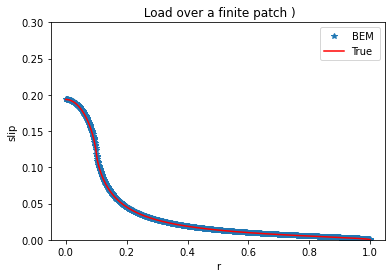

In [6]:
R_w=0.1
xcorr,dd_sol,w_true,rmse,l2rel = solvePennyShaped_finite_patch_shear(1000,a=1,a_w=R_w,kernel="Axi3DP0")

plt.plot(xcorr, dd_sol[:,0], "*")
plt.plot(xcorr, w_true, "-r") 
plt.title(' Load over a finite patch )')
plt.xlabel("r")
plt.ylabel("slip")
plt.ylim([0.,0.3])
plt.legend(['BEM ','True'])




Text(0.5, 1.0, 'relative error (r)')

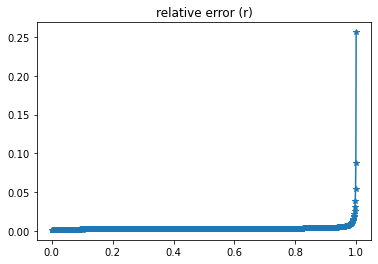

In [7]:
plt.plot(xcorr[:],(dd_sol[:,0]-w_true[:])/w_true[:], "-*") #
#plt.plot(xcorr, w_true, "-+r") 
plt.title('relative error (r)')